### Notebook Introduction

This notebook is dedicated for exploratory data analysis of the Home Credit Group dataset. We will explore what relations exist between the target and independent features and also how could we use this information when building those models.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", None)
import functions as f
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
PATH = "../Data/home-credit-default-risk"
df_1 = pd.read_csv(PATH + "/cash_loans.csv.zip", index_col=0)
df_2 = pd.read_csv(PATH + "/revolving_loans.csv.zip", index_col=0)
df_1 = f.convert_types(df_1, print_info=True)
df_2 = f.convert_types(df_2, print_info=True)

Original Memory Usage: 1.32 gb.
New Memory Usage: 0.59 gb.
Original Memory Usage: 0.13 gb.
New Memory Usage: 0.06 gb.


In [3]:
cash_loans_train, cash_loans_test = train_test_split(
    df_1, test_size=0.2, random_state=42
)
revolving_loans_train, revolving_loans_test = train_test_split(
    df_2, test_size=0.2, random_state=42
)

In [4]:
# cash_loans_train.to_csv(PATH+"/cash_loans_train.csv.zip", index=False)
# cash_loans_test.to_csv(PATH+"/cash_loans_test.csv.zip", index=False)
# revolving_loans_train.to_csv(PATH+"/revolving_loans_train.csv.zip", index=False)
# revolving_loans_test.to_csv(PATH+"/revolving_loans_test.csv.zip", index=False)

In [5]:
cash_loans = cash_loans_train.copy()
revolving_loans = revolving_loans_train.copy()

In [6]:
cash_loans["target_str"] = cash_loans["target"].map(
    {0: "other cases", 1: "loan default"}
)
revolving_loans["target_str"] = revolving_loans["target"].map(
    {0: "other cases", 1: "loan default"}
)

In [7]:
def plot_target_dist(data, palette):
    df = data["target_str"].value_counts(normalize=True)
    df = df.mul(100)
    df = df.rename("percent").reset_index()
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.barplot(data=df, x="target_str", y="percent", palette=palette, ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Other cases", "Loan default"])
    ax.set_xlabel("")
    ax.set_title("Target distribution")
    sns.despine()
    for label in ax.containers:
        ax.bar_label(label, fmt="%.2f%%")

## Cash loans

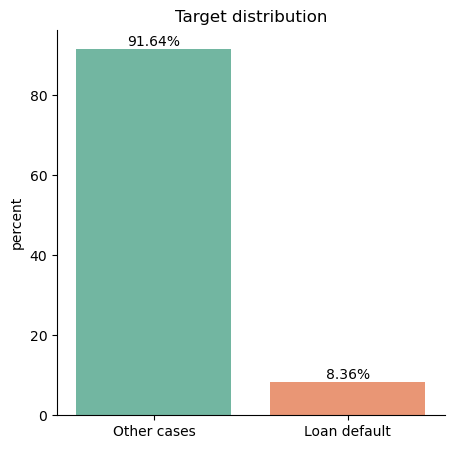

In [8]:
palette=sns.set_palette("Set2", 2)
plot_target_dist(cash_loans, palette)

The target distribution is highly imbalanced. We will need to deal with this issue by altering the models class weight parameters.

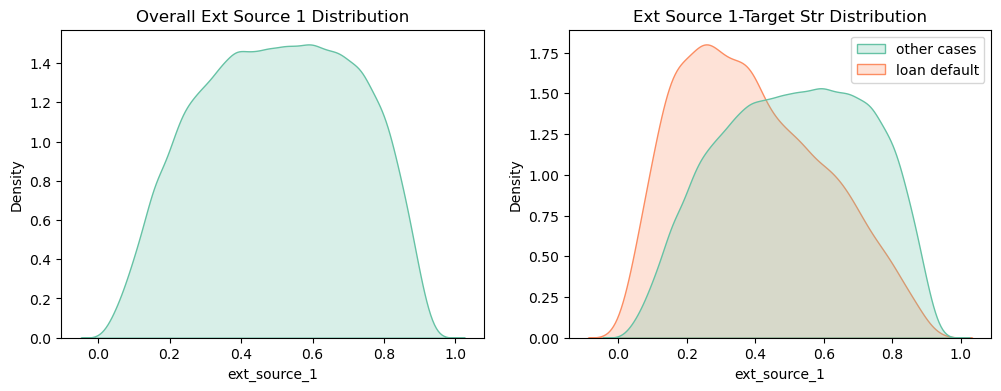

In [9]:
f.distribution_plot(cash_loans, col="ext_source_1", hue="target_str", palette=palette)

In [10]:
res = mannwhitneyu(
    cash_loans["ext_source_1"][cash_loans["target"] == 0],
    cash_loans["ext_source_1"][cash_loans["target"] == 1],
    alternative="two-sided",
    nan_policy="omit",
)
res

MannwhitneyuResult(statistic=441634445.5, pvalue=0.0)

It seems that there is a difference between the distributions of classes in the external source 1 feature. And after performing a Mann-Whitney U test we can confirm that the difference is statistically significant.

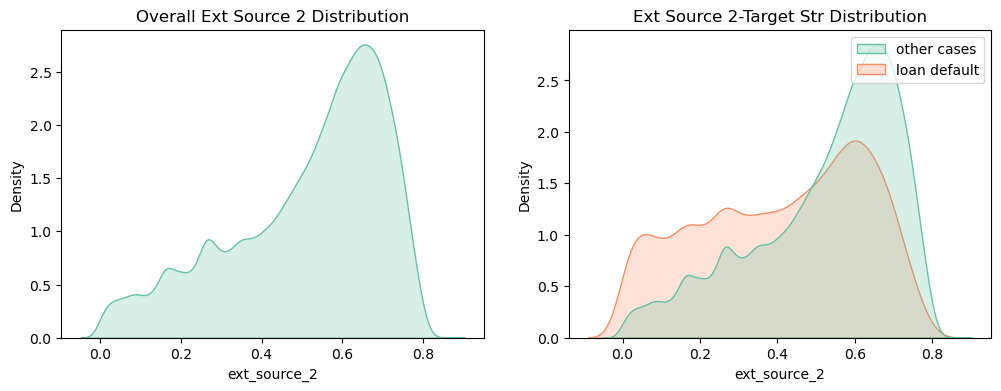

In [11]:
f.distribution_plot(cash_loans, col="ext_source_2", hue="target_str", palette=palette)

In [12]:
res = mannwhitneyu(
    cash_loans["ext_source_2"][cash_loans["target"] == 0],
    cash_loans["ext_source_2"][cash_loans["target"] == 1],
    alternative="two-sided",
    nan_policy="omit",
)
res

MannwhitneyuResult(statistic=2478207300.5, pvalue=0.0)

It seems that there is a difference between the distributions of classes in the external source 2 feature. And after performing a Mann-Whitney U test we can confirm that the difference is statistically significant.

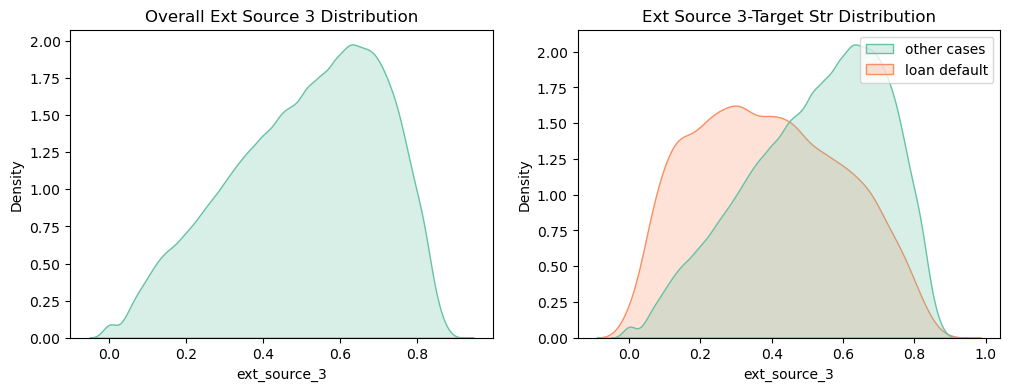

In [13]:
f.distribution_plot(cash_loans, col="ext_source_3", hue="target_str", palette=palette)

In [14]:
res = mannwhitneyu(
    cash_loans["ext_source_3"][cash_loans["target"] == 0],
    cash_loans["ext_source_3"][cash_loans["target"] == 1],
    alternative="two-sided",
    nan_policy="omit",
)
res

MannwhitneyuResult(statistic=1604752802.0, pvalue=0.0)

It seems that there is a difference between the distributions of classes in the external source 3 feature. And after performing a Mann-Whitney U test we can confirm that the difference is statistically significant.

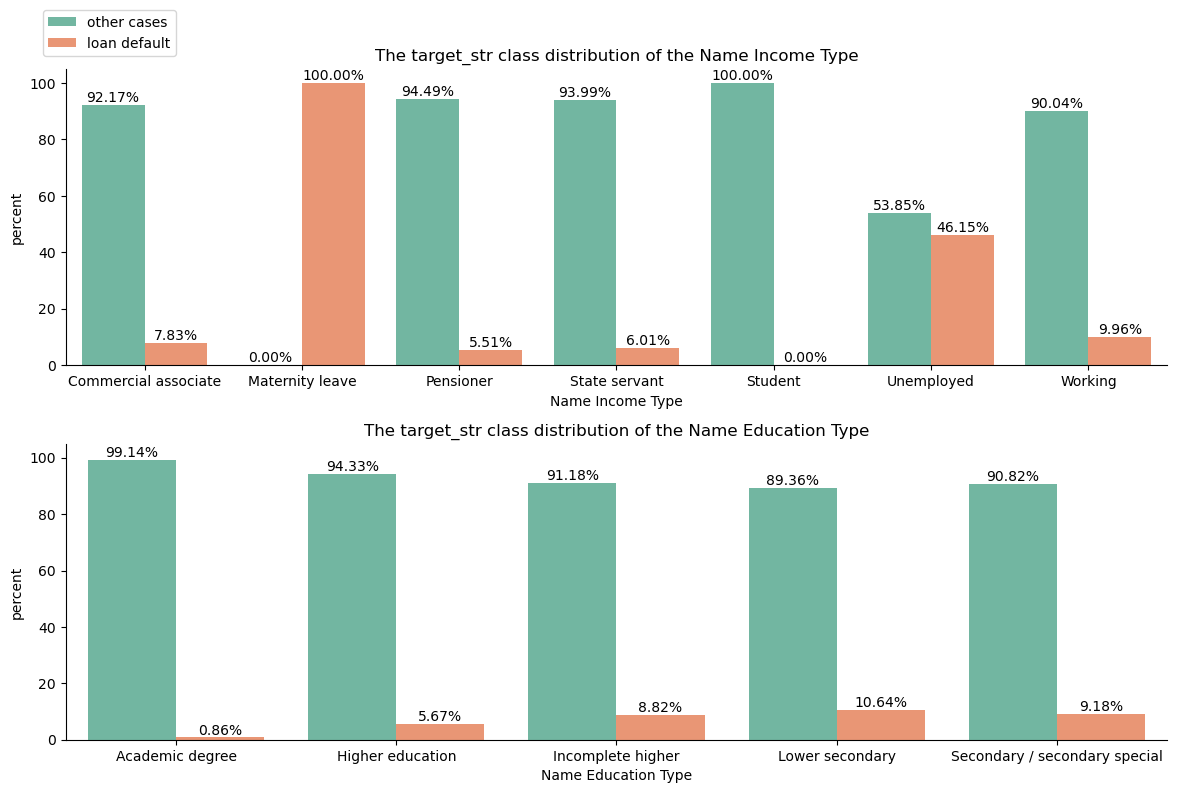

In [15]:
f.normalized_barplots(
    cash_loans,
    cols=[
        "name_income_type",
        "name_education_type",
    ],
    hue="target_str",
    grid_x=1,
    grid_y=2,
    palette=palette,
    figsize=(12, 8),
    legend_loc=(0.1, 1.2)
)

After looking at these barplots we can see that the distributions of classes in these categorical features are all uneven. This could mean that these features could be potentially important in model training. Also the name education type feature is ordinal, so we will need to encode it in correct order.

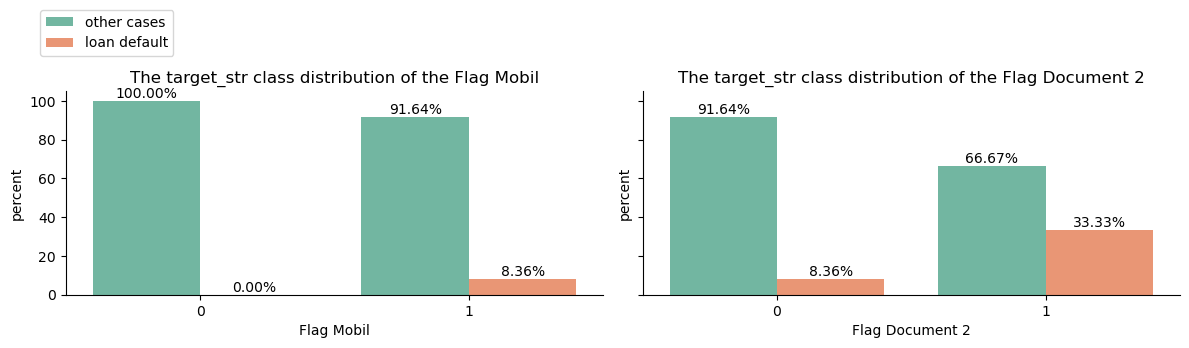

In [16]:
f.normalized_barplots(
    cash_loans,
    cols=[
        "flag_mobil",
        "flag_document_2",
    ],
    hue="target_str",
    grid_x=2,
    grid_y=1,
    palette=palette,
    figsize=(12, 4),
    legend_loc=(0.2, 1.4)
)

These two categorical features also have uneven distributions so they also could be important.

### Correlation
To calculate the correlation between the target and independent features. For this task I picked the Point Biserial Correlation, because I wanted to try a new method and this one is used when you want to measure the relationship between a continuous variable and a dichotomous variable, or one that has two values. So It would be perfect for our task because our Target is a binary variable. But as I learned later this method produces the same results as the Pearson correlation coefficient so there is no point of using it. But for this project I will stick withh it.

In [17]:
corr, pval = f.corr_cat_vs_cont(
    cash_loans,
    cat=["target"],
    cont=cash_loans.select_dtypes(include="number").columns.to_list(),
)

In [18]:
corr[corr["target"].abs() > 0.05].sort_values(by="target", ascending=False)

,target
mean_bureau_days_credit,0.090807
days_birth,0.081814
min_bureau_days_credit,0.077026
days_employed,0.076814
mean_bureau_days_credit_update,0.068987
std_previous_application_days_first_drawing,0.066378
region_rating_client_w_city,0.059949
std_previous_application_min_installments_payments_num_instalment_version,0.058899
region_rating_client,0.058608
min_installments_payments_days_entry_payment,0.05859


After looking at the correlation between the target and all the continuous features we can see that non of them are highly correlated. The features with the highest correlation are all the external sources features.

### Average credit amount for each target class

In [19]:
cash_loans.groupby("target_str")["amt_credit"].mean()

target_str
other cases     632594.00
loan default    578548.25
Name: amt_credit, dtype: float32

The mean amount of credit for revolving defaulted loans is **578k** while for the other cases it is **632k**. Knowing that we could estimate the loses for the bank with and without the model and then evaluate the models performance.

## Revolving loans

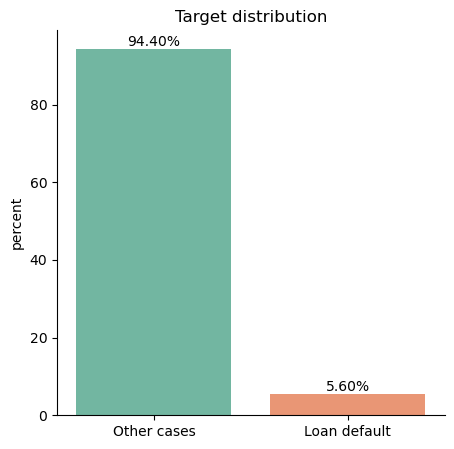

In [20]:
palette=sns.set_palette("Set2", 2)
plot_target_dist(revolving_loans, palette)

The target distribution is highly imbalanced. We will need to deal with this issue by altering the models class weight parameters.

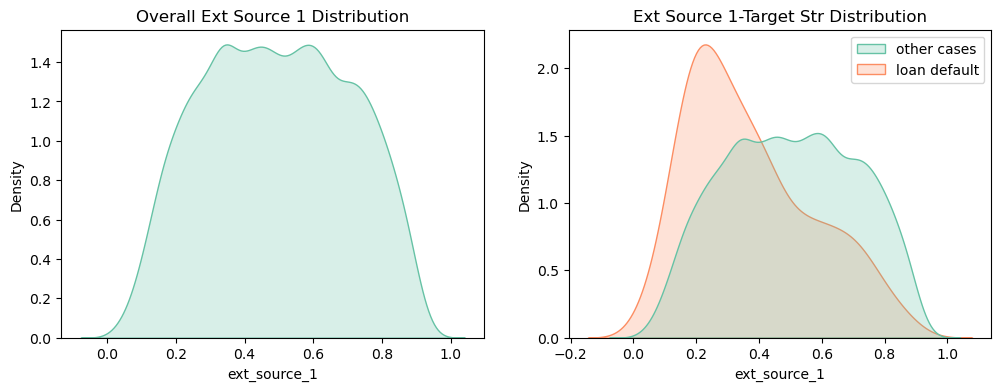

In [21]:
f.distribution_plot(
    revolving_loans, col="ext_source_1", hue="target_str", palette=palette
)

In [22]:
res = mannwhitneyu(
    revolving_loans["ext_source_1"][revolving_loans["target"] == 0],
    revolving_loans["ext_source_1"][revolving_loans["target"] == 1],
    alternative="two-sided",
    nan_policy="omit",
)
res

MannwhitneyuResult(statistic=3951396.5, pvalue=5.406103528165396e-44)

It seems that there is a difference between the distributions of classes in the external source 1 feature. And after performing a Mann-Whitney U test we can confirm that the difference is statistically significant.

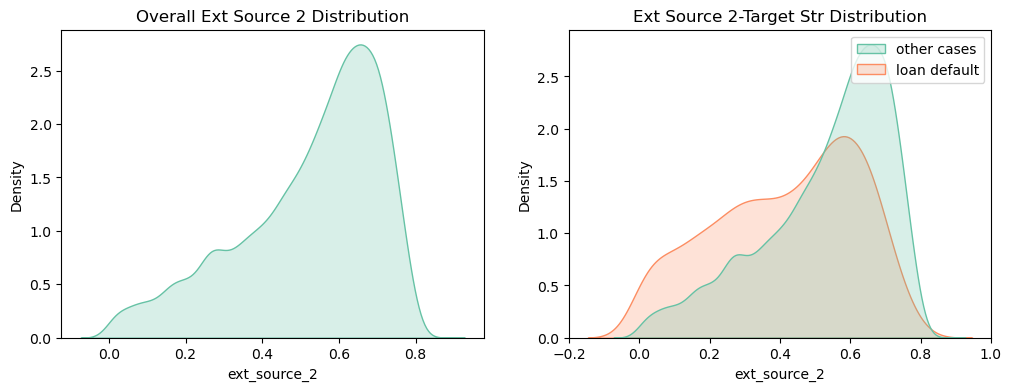

In [23]:
f.distribution_plot(
    revolving_loans, col="ext_source_2", hue="target_str", palette=palette
)

In [24]:
res = mannwhitneyu(
    revolving_loans["ext_source_2"][revolving_loans["target"] == 0],
    revolving_loans["ext_source_2"][revolving_loans["target"] == 1],
    alternative="two-sided",
    nan_policy="omit",
)
res

MannwhitneyuResult(statistic=19197456.0, pvalue=4.4552391167043844e-89)

It seems that there is a difference between the distributions of classes in the external source 2 feature. And after performing a Mann-Whitney U test we can confirm that the difference is statistically significant.

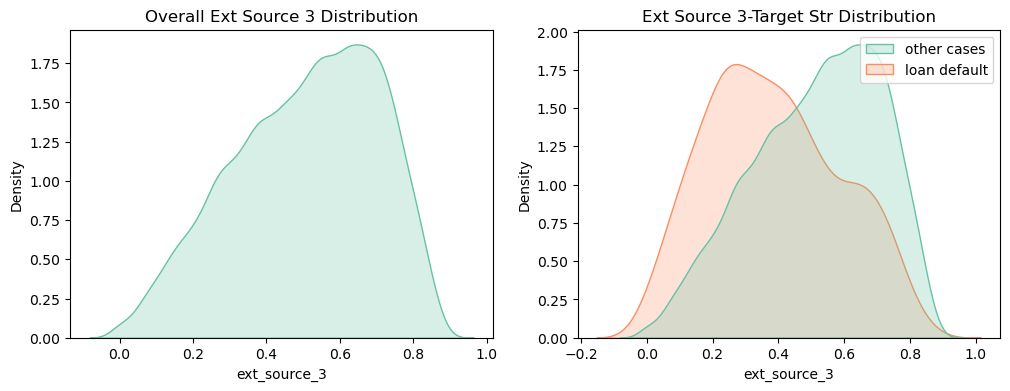

In [25]:
f.distribution_plot(
    revolving_loans, col="ext_source_3", hue="target_str", palette=palette
)

In [26]:
res = mannwhitneyu(
    revolving_loans["ext_source_3"][revolving_loans["target"] == 0],
    revolving_loans["ext_source_3"][revolving_loans["target"] == 1],
    alternative="two-sided",
    nan_policy="omit",
)
res

MannwhitneyuResult(statistic=11616190.5, pvalue=1.6932573276621448e-81)

It seems that there is a difference between the distributions of classes in the external source 3 feature. And after performing a Mann-Whitney U test we can confirm that the difference is statistically significant.

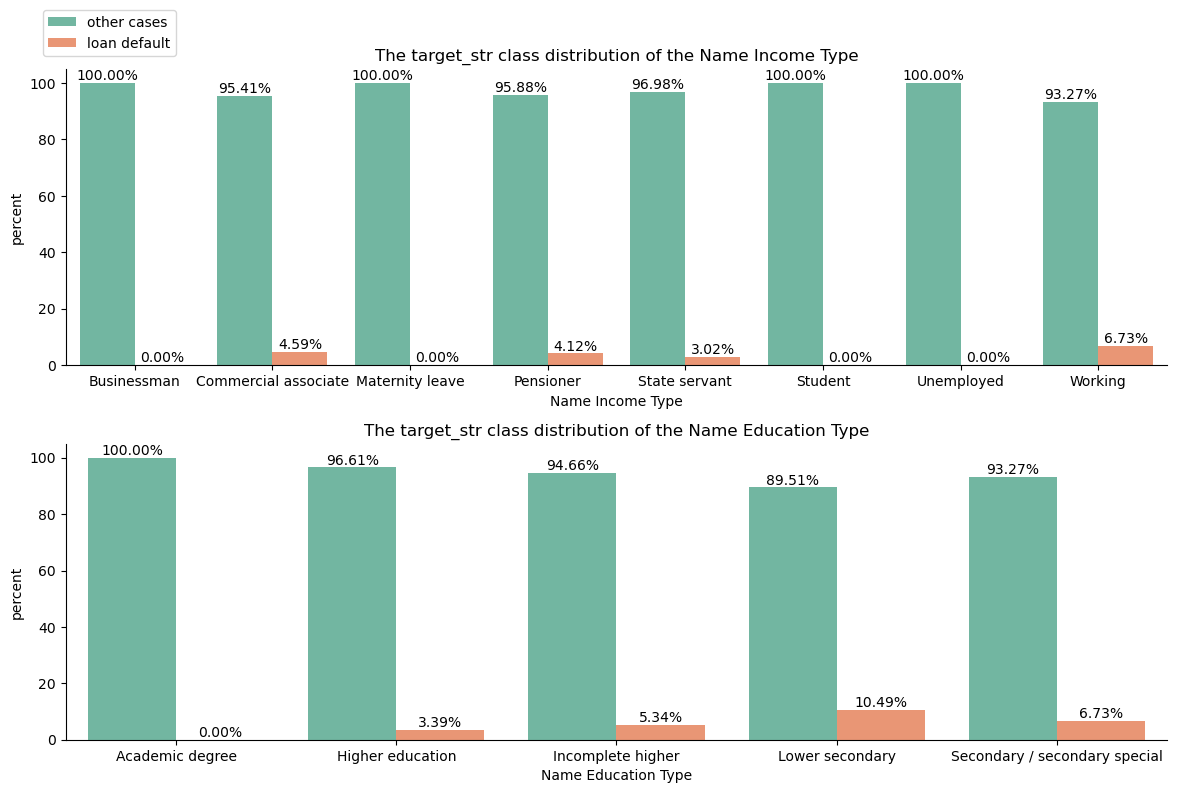

In [27]:
f.normalized_barplots(
    revolving_loans,
    cols=[
        "name_income_type",
        "name_education_type",
    ],
    hue="target_str",
    grid_x=1,
    grid_y=2,
    palette=palette,
    figsize=(12, 8),
    legend_loc=(0.1, 1.2)
)

After looking at these barplots we can see that the distributions of classes in these categorical features are all uneven. This could mean that these features could be potentially important in model training. Also the name education type feature is ordinal, so we will need to encode it in correct order.

### Correlation

In [33]:
cash_loans.dtypes

target                                                                      category
name_contract_type                                                          category
code_gender                                                                 category
flag_own_car                                                                category
flag_own_realty                                                             category
                                                                              ...   
std_installments_payments_previous_application_hour_appr_process_start       float32
std_installments_payments_previous_application_nflag_insured_on_approval     float32
std_installments_payments_previous_application_rate_down_payment             float32
std_installments_payments_previous_application_sellerplace_area              float32
target_str                                                                  category
Length: 593, dtype: object

In [36]:
corr, pval = f.corr_cat_vs_cont(
    revolving_loans,
    cat=["target"],
    cont=revolving_loans.select_dtypes(include="number").columns.to_list(),
)

In [37]:
corr[corr["target"].abs() > 0.05].sort_values(by="target", ascending=False)

,target
mean_bureau_days_credit,0.089829
min_bureau_days_credit,0.081534
days_employed,0.075578
days_id_publish,0.071644
days_birth,0.07124
mean_bureau_days_credit_update,0.06624
min_bureau_days_enddate_fact,0.058361
mean_bureau_days_enddate_fact,0.0576
days_last_phone_change,0.056794
min_previous_application_days_decision,0.056133


After looking at the correlation between the target and all the continuous features we can see that non of them are highly correlated. The features with the highest correlation are all the external sources features.

### Average credit amount for each target class

In [38]:
revolving_loans.groupby("target_str")["amt_credit"].mean()

target_str
other cases     327874.593750
loan default    255937.515625
Name: amt_credit, dtype: float32

The mean amount of credit for revolving defaulted loans is **255k** while for the other cases it is **327k**. Knowing that we could estimate the loses for the bank with and without the model and then evaluate the models performance.